# 1 - Imports

In [70]:
# native packages
import os, logging, warnings, json, functools, time, itertools, collections

# some setup
warnings.filterwarnings('ignore', module='tqdm.auto')  # deprication warnings
warnings.filterwarnings('ignore', module='sklearn.neural_network._multilayer_perceptron')  # convergence warnings
logger = logging.getLogger(__name__)

# other packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from scipy.stats import kurtosis

# more setup
plt.rcParams['font.size'] = 14 # Set default font size to 14

# custom package
import ul_utils

# sklearn imports
from sklearn import svm
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, 
    adjusted_rand_score,
    adjusted_mutual_info_score,  
    fowlkes_mallows_score,
    completeness_score,
    v_measure_score,
    silhouette_score  # does not care about labels
)
from sklearn.neural_network import (
    MLPClassifier
)
from sklearn.mixture import (  # EM... options!
    GaussianMixture,
    BayesianGaussianMixture
) 
from sklearn.cluster import KMeans
from sklearn.random_projection import (  # so many options!
    GaussianRandomProjection,
    SparseRandomProjection
)
from sklearn.decomposition import (
    PCA, 
    FastICA
)

# 2 - Setup


## 2.1 - Get Data and Globals

In [ ]:
# download data from kaggle and set up loader - global
DATA = ul_utils.Report_Data()
DATA.set_up_data()

# experiment directory - global
EXPERIMENT_NAME = 'ul_5'  # global experiment name
if not os.path.exists(DATA.root+f'logs/{EXPERIMENT_NAME}/'):
    os.mkdir(DATA.root+f'logs/{EXPERIMENT_NAME}/')

# SL results directory - global
# SL_RESULTS_NAME = 'sl_results_classification'  # global var
# if not os.path.exists(DATA.root+f'logs/{SL_RESULTS_NAME}/'):
#     os.mkdir(DATA.root+f'logs/{SL_RESULTS_NAME}/')

Already have Cancer Dataset
Cancer Demo Saved
Already Have Bankruptcy Dataset
Bankruptcy Demo Saved


## 2.2 - Utility Functions

In [63]:
# clean up cancer data categorical features
def clean_cancer_data(raw_cancer_df, target='Cancer_Type'):
    meta = ['Year', 'Patient_ID']
    # targets = [col for col in ['Treatment_Cost_USD', 'Survival_Years', 'Target_Severity_Score'] if col!=target]
    categoricals = [col for col in ['Gender', 'Country_Region', 'Cancer_Type', 'Cancer_Stage'] if col!=target]

    # drop metadata and target, then get dummies
    cancer_inputs = pd.get_dummies(
        raw_cancer_df.drop(meta+[target], axis=1),
        columns = categoricals,
        drop_first = True
        )
    
    # format output col, if categorical
    if not pd.api.types.is_string_dtype(raw_cancer_df[target]):
        cancer_target = raw_cancer_df[target]
    else:
        uniques = list(raw_cancer_df[target].unique())
        cancer_target = raw_cancer_df[target].apply(lambda val: uniques.index(val))
    
    # return
    return cancer_inputs, cancer_target

def apply_clusterer(clusterer, n_classes, data, target, metric, **kwargs):
    clust = clusterer(n_classes, random_state=7, **kwargs).fit(data)  # hard-coded random state
    pred = clust.predict(data)
    score = metric(pred, target.tolist())
    return clust, pred, score

def plot_according_to(data, cols, labels, colors):
    pairs = [(col1, col2) for col1, col2 in itertools.product(cols, cols) if col1<col2]
    for x, y in pairs:
        sns.scatterplot(data=data, x=x, y=y, c=[colors[clust] for clust in labels], alpha=0.5)
        plt.title(f'{x} vs {y} Cluster Visualization')
        plt.show()

def plot_2D(reducer, data, title, labels, colors, **kwargs):
    data_2D = reducer(n_components=2, random_state=7, **kwargs).fit_transform(data)
    sns.scatterplot(x=data_2D[:, 0], y=data_2D[:, 1], c=[colors[clust] for clust in labels], alpha=0.5)
    plt.title(title)
    plt.show()
    return data_2D

class NoReducer:
    def __init__(self, **kwargs):
        pass
    def __bool__(self):
        return False
    @staticmethod
    def fit_transform(data):
        return data

def get_experiment_results(reducers, models, n_components, n_clusters, metric, inputs, targets, filename, reducer_args, clusterer_args, multiclass):
    log_path = f'{DATA.root}logs/{EXPERIMENT_NAME}/{filename}'
    if multiclass:
        classes = [int(x) for x in list(set(targets))]
    if os.path.exists(log_path):
        with open(log_path, 'r') as file:
            return json.load(file)
    else:
        results = []
        if not isinstance(n_components, collections.abc.Iterable):  # if given single n_components, cast to list
            n_components = [n_components]
        ran_none = {}
        for reducer, model, n in tqdm(itertools.product(reducers, models, n_components), total=len(reducers)*len(models)*len(n_components)):
            if reducer.__class__.__name__ == 'partial':
                reducer_name = reducer.func.__name__
            else:
                reducer_name = reducer.__name__
            if model.__class__.__name__ == 'partial':
                model_name = model.func.__name__
            else:
                model_name = model.__name__
            if model_name not in ran_none:
                ran_none.update({model_name: False})
            if reducer_name=='NoReducer' and ran_none:
                continue
            else:
                if reducer:
                    tmp_inputs = reducer(n_components=n, **reducer_args).fit_transform(inputs)
                else:
                    tmp_inputs = inputs
                clusterer = model(n_clusters, **clusterer_args).fit(tmp_inputs)
                if not multiclass:
                    preds = clusterer.predict(tmp_inputs)
                    if metric.__class__.__name__ == 'partial':
                        metric_name = metric.func.__name__
                    else:
                        metric_name = metric.__name__
                    score = metric(preds, list(targets))
                    results.append({
                        'reducer': reducer_name,
                        'model': model_name,
                        'metric': metric_name,
                        'score': round(score, 3),  # only care so much about precision
                        'n_components': tmp_inputs.shape[1],
                        'n_clusters': n_clusters
                    })
                else:
                    for c in classes:
                        tmp_preds = [pred==c for pred in clusterer.predict(tmp_inputs)]
                        tmp_target = [tar==c for tar in targets]
                        if metric.__class__.__name__ == 'partial':
                            metric_name = metric.func.__name__
                        else:
                            metric_name = metric.__name__
                        score = metric(tmp_preds, list(tmp_target))
                        results.append({
                            'reducer': reducer_name,
                            'model': model_name,
                            'metric': metric_name,
                            'score': round(score, 3),  # only care so much about precision
                            'n_components': tmp_inputs.shape[1],
                            'n_clusters': n_clusters,
                            'target_class': c
                        })

                if reducer_name == 'NoReducer':
                    ran_none[model_name] = True
        with open(log_path, 'w+') as file:
            json.dump(results, file)
        return results
    
class BestColReducer:
    __name__='Best'
    def __init__(self, best_cols, **kwargs):
        self.best_cols = best_cols
    def __bool__(self):
        return True
    def fit(self, data):
        return self
    def transform(self, data):
        return data[self.best_cols]
    def fit_transform(self, data):
        return data[self.best_cols]

def sl_experiment(model, reducers, n_components, metric, X, y, filename, reducer_args):
    log_path = f'{DATA.root}logs/{EXPERIMENT_NAME}/{filename}'
    if not os.path.exists(log_path):
        results = []
        ran_none = False
        ran_best = False
        for R, nc in tqdm(itertools.product(reducers, n_components), total=len(reducers)*len(n_components)):
            if R.__class__.__name__ == 'partial':
                reducer_name = R.func.__name__
            else:
                reducer_name = R.__name__
            if reducer_name == 'NoReducer' and ran_none:
                continue
            elif reducer_name == 'BestColReducer' and ran_best:
                continue
            else:
                if reducer_name != 'NoReducer':
                    R_fit = R(n_components=nc, **reducer_args).fit(X['train'])
                    X_train, X_test = R_fit.transform(X['train']), R_fit.transform(X['test'])
                else:
                    X_train, X_test = X['train'], X['test']
                model = model.fit(X_train, y['train'])
                if metric.__class__.__name__ == 'partial':
                    metric_name = metric.func.__name__
                else:
                    metric_name = metric.__name__
                score = metric(y['test'], model.predict(X_test))
                results.append({
                    'model': model.__class__.__name__,
                    'reducer': reducer_name,
                    'n_components': X_train.shape[1],
                    'metric': metric_name,
                    'score': round(score, 3)  # only care so much about precision
                })
                if reducer_name == 'NoReducer':
                    ran_none = True
                elif reducer_name == 'BestColReducer':
                    ran_best = True
        with open(log_path, 'w+') as file:
            json.dump(results, file)
        return results
    else:
        with open(log_path, 'r') as file:
            return json.load(file)

def plot_results(expr, results):
    if 'models' not in expr.keys() and 'model' in expr.keys():
        expr['models'] = [expr['model']]
    elif 'models' not in expr.keys():
        expr['models'] = [None]
    for model in expr['models']:
        if not model:
            model_name = None
        elif model.__class__.__name__ == 'partial':
            model_name = model.func.__name__
        elif model.__class__.__name__ != 'ABCMeta':
            model_name = model.__class__.__name__
        else:
            model_name = model.__name__
        model_results = [r for r in results if r['model']==model_name]
        for reducer in expr['reducers']:
            if reducer.__class__.__name__ == 'partial':
                reducer_name = reducer.func.__name__
            else:
                reducer_name = reducer.__name__
            tmp_results = [r for r in model_results if r['reducer']==reducer_name]
            metric = expr['metric']
            if metric.__class__.__name__ == 'partial':
                metric_name = metric.func.__name__
            else:
                metric_name = metric.__name__
            if 'multiclass' in expr and expr['multiclass']:
                sum_by_ncomp = [0] * len(list(set([r['n_components'] for r in tmp_results])))
                for c in sorted(list(set(expr['targets']))):
                    tmp_tmp_results = sorted([r for r in tmp_results if r['target_class']==c], key=lambda r: r['n_components'])
                    plt.plot(
                        [r['n_components'] for r in tmp_tmp_results], 
                        [r['score'] for r in tmp_tmp_results],
                        alpha=0.5,
                        label = c
                    )
                    for i in range(len(sum_by_ncomp)):
                        sum_by_ncomp[i] += [r['score'] for r in tmp_tmp_results][i]
                avg_by_ncomp = [x/len(list(set(expr['targets']))) for x in sum_by_ncomp]
                plt.plot(
                    range(1, len(avg_by_ncomp)+1), 
                    avg_by_ncomp,
                    label = 'avg',
                    color='black',
                    linewidth=2
                )
                plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            else:
                tmp_tmp_results = sorted(tmp_results, key=lambda r: r['n_components'])
                plt.plot(
                        [r['n_components'] for r in tmp_tmp_results], 
                        [r['score'] for r in tmp_tmp_results],
                        alpha=0.5
                    )
            if model:
                plt.title(f'{model_name} + {reducer_name}')
            else:
                plt.title(reducer_name)
            plt.xlabel('# Features')
            plt.ylabel(metric_name)
            # 
            plt.show()

def log_cluster_results(data, labels, preds, colors, filename):
    log_path = f'{DATA.root}logs/{EXPERIMENT_NAME}/{filename}'
    if not os.path.exists(log_path):
        pairs = [(col1, col2) for col1, col2 in itertools.product(data.columns, data.columns) if col1<col2]
        if not pairs:  # only one feature
            with PdfPages(log_path) as pdf:
                fig = plt.figure()
                plt.scatter(data, data, c=[colors[clust] for clust in labels], alpha=0.5, rasterized=True)
                plt.title(f'Truth')
                fig.savefig(pdf, format='pdf', bbox_inches='tight')
                plt.close(fig)
                # preds
                fig = plt.figure()
                plt.scatter(data, data, c=[colors[clust] for clust in preds], alpha=0.5, rasterized=True)
                plt.title(f'Cluster Label')
                fig.savefig(pdf, format='pdf', bbox_inches='tight')
                plt.close(fig)
        else:
            with PdfPages(log_path) as pdf:
                for x, y in tqdm(pairs):
                    if data[x].nunique() > 2 and data[y].nunique() > 2:  # non-binary, worth seeing
                        # truth
                        fig = plt.figure()
                        plt.scatter(data[x], data[y], c=[colors[clust] for clust in labels], alpha=0.5, rasterized=True)
                        plt.title(f'Truth')
                        plt.xlabel(x)
                        plt.ylabel(y)
                        fig.savefig(pdf, format='pdf', bbox_inches='tight')
                        plt.close(fig)
                        # preds
                        fig = plt.figure()
                        plt.scatter(data[x], data[y], c=[colors[clust] for clust in preds], alpha=0.5, rasterized=True)
                        plt.title(f'Cluster Label')
                        plt.xlabel(x)
                        plt.ylabel(y)
                        fig.savefig(pdf, format='pdf', bbox_inches='tight')
                        plt.close(fig)

def apply_robust_scaler(data):
    cols = data.columns
    return pd.DataFrame(RobustScaler().fit_transform(data), columns=cols)

# 3 - Cancer

In [4]:
# cancer data setup
cancer_data = DATA.get_cancer_full()
cancer_inputs, cancer_target = clean_cancer_data(cancer_data, target='Cancer_Stage')
cancer_inputs = apply_robust_scaler(cancer_inputs)
cancer_interesting_cols = ['Target_Severity_Score', 'Genetic_Risk', 'Air_Pollution']
n_cancer_classes = len(cancer_target.unique())
print('N Types of Cancer:', n_cancer_classes)

N Types of Cancer: 5


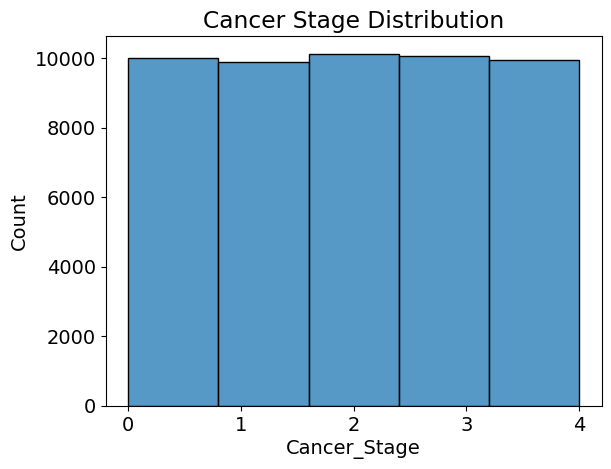

In [5]:
sns.histplot(cancer_target, bins=n_cancer_classes)
plt.title('Cancer Stage Distribution')
plt.show()

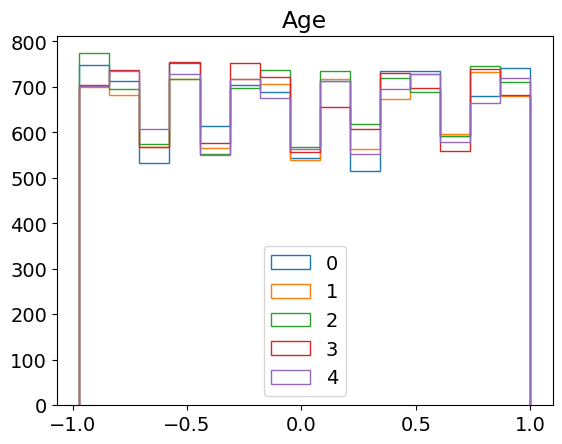

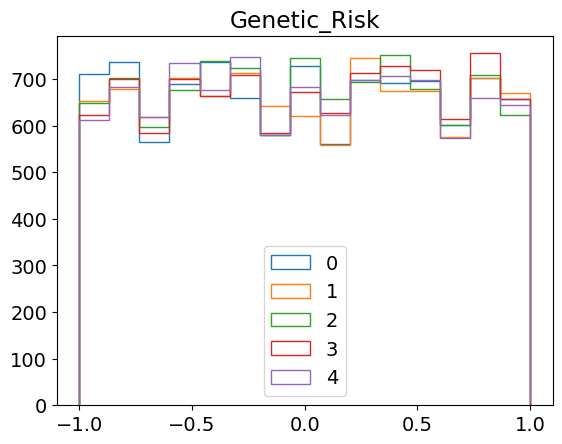

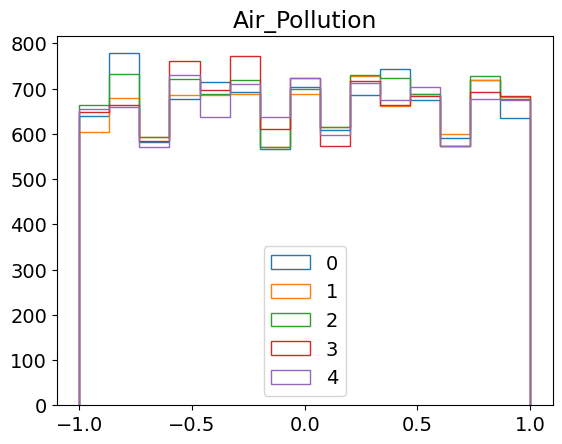

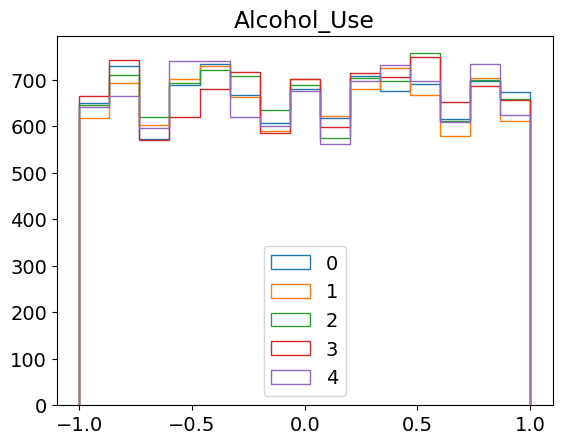

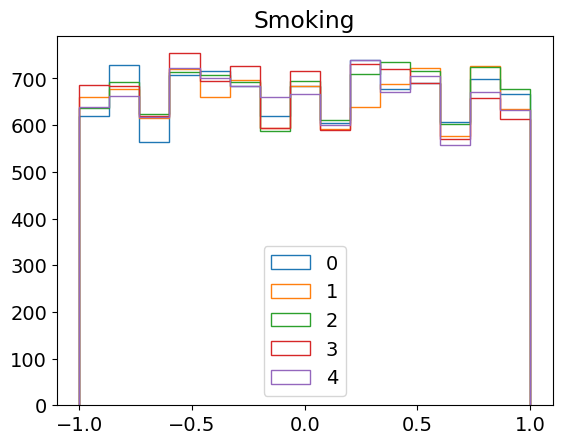

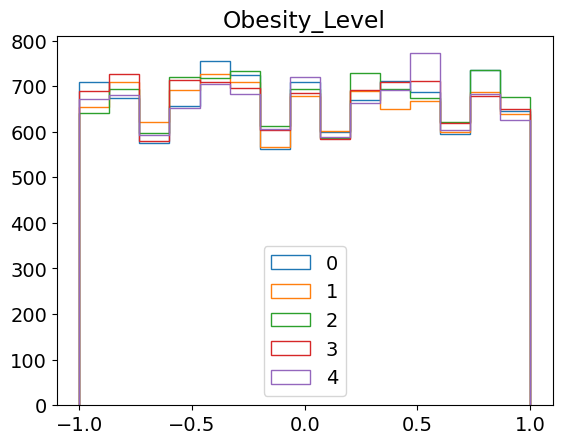

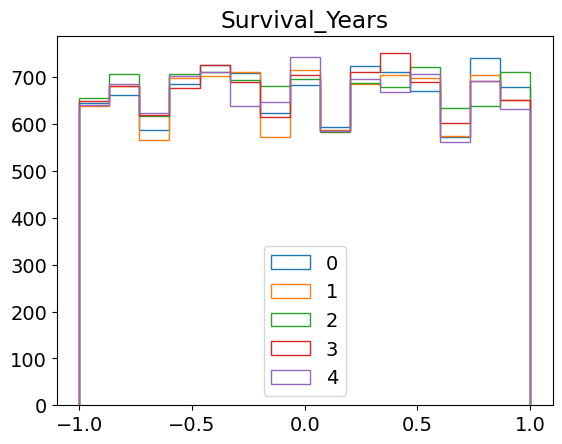

In [6]:
for col in cancer_inputs.columns:
    if cancer_inputs[col].nunique() > 2:
        for label in range(cancer_target.nunique()):
            tmp_inputs = cancer_inputs[cancer_target==label]
            plt.hist(tmp_inputs[col], label=label, color=sns.color_palette('tab10')[label], histtype='step', bins=15)
        plt.title(col)
        plt.legend()
        plt.show()

In [7]:
# for x in ['Genetic_Risk', 'Air_Pollution', 'Alcohol_Use', 'Smoking', 'Obesity_Level', 'Age']:
#     sns.kdeplot(data=cancer_data, x=x, y='Target_Severity_Score')
#     sns.rugplot(data=cancer_data, x=x, y='Target_Severity_Score')
#     plt.title(f'{x} vs. TSS Distribution')
#     plt.show()

## 3.1 - Clustering

### 3.1.1 - EM

In [8]:
clust, pred, score = apply_clusterer(GaussianMixture, n_cancer_classes, cancer_inputs, cancer_target, adjusted_mutual_info_score)
print('Score:', score)
# plot_according_to(cancer_inputs, cancer_interesting_cols, pred, sns.color_palette('tab10'))
log_cluster_results(cancer_inputs, cancer_target, pred, sns.color_palette('tab10'), 'Cancer_EM_Clustering.pdf')

Score: -5.618219679771287e-05


### 3.1.2 - K-Means

In [9]:
clust, pred, score = apply_clusterer(KMeans, n_cancer_classes, cancer_inputs, cancer_target, fowlkes_mallows_score)
print('Score:', score)
# plot_according_to(cancer_inputs, cancer_interesting_cols, pred, sns.color_palette('tab10'))
log_cluster_results(cancer_inputs, cancer_target, pred, sns.color_palette('tab10'), 'Cancer_KMeans_Clustering.pdf')

Score: 0.20029803420206346


## 3.2 - Linear Dimensionality Reduction

### 3.2.1 - Randomized Projections

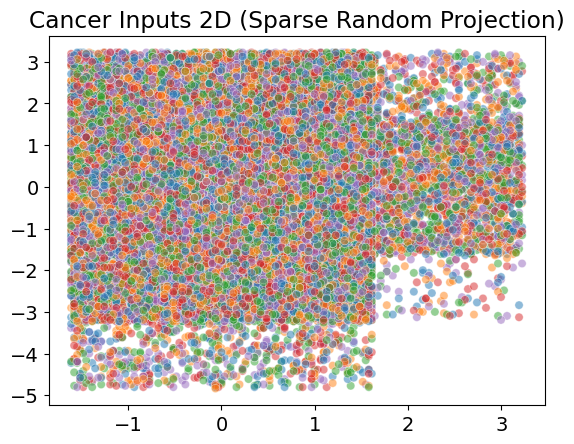

In [10]:
cancer_inputs_sparse_2D = plot_2D(SparseRandomProjection, cancer_inputs, 'Cancer Inputs 2D (Sparse Random Projection)', cancer_target, sns.color_palette('tab10'))

In [11]:
try:
    tmp = SparseRandomProjection(random_state=7).fit_transform(cancer_inputs)
    print(tmp.shape[1])
except Exception as e:
    print(e)

eps=0.100000 and n_samples=50000 lead to a target dimension of 9274 which is larger than the original space with n_features=27


### 3.2.2 - PCA

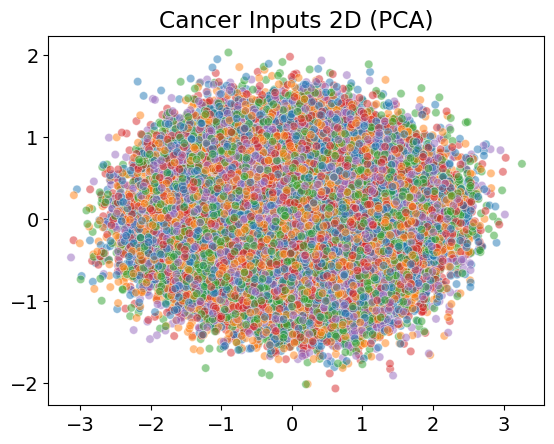

In [12]:
cancer_inputs_PCA_2D = plot_2D(PCA, cancer_inputs, 'Cancer Inputs 2D (PCA)', cancer_target, sns.color_palette('tab10'))

In [13]:
try:
    tmp = PCA(random_state=7).fit_transform(cancer_inputs)
    print(tmp.shape[1])
except Exception as e:
    print(e)

27


### 3.2.3 - ICA

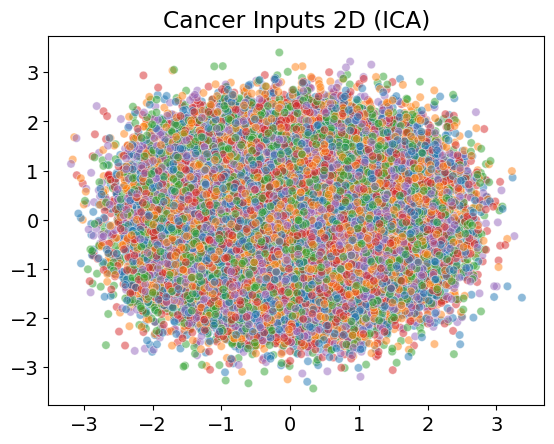

In [14]:
cancer_inputs_ICA_2D = plot_2D(FastICA, cancer_inputs, 'Cancer Inputs 2D (ICA)', cancer_target, sns.color_palette('tab10'))

In [15]:
try:
    tmp = FastICA(random_state=7).fit_transform(cancer_inputs)
    print(tmp.shape[1])
except Exception as e:
    print(e)

27


## 3.3 - Experiments

In [16]:
model_scores = [[], []]
for i in range(5):
    tmp_labels = cancer_target.apply(lambda x: x==i)
    for i, model in enumerate([GaussianMixture, KMeans]):
        preds = model(5, random_state=7).fit(cancer_inputs).predict(cancer_inputs)
        fm_score = round(fowlkes_mallows_score(tmp_labels, preds), 3)
        print(f'({model.__name__}) Class {i} Fowlkes-Mallows Score: {fm_score}')
        model_scores[i].append(fm_score)

for scores, model in zip(model_scores, [GaussianMixture, KMeans]):
    print(model.__name__, np.mean(scores))

(GaussianMixture) Class 0 Fowlkes-Mallows Score: 0.41
(KMeans) Class 1 Fowlkes-Mallows Score: 0.369
(GaussianMixture) Class 0 Fowlkes-Mallows Score: 0.411
(KMeans) Class 1 Fowlkes-Mallows Score: 0.37
(GaussianMixture) Class 0 Fowlkes-Mallows Score: 0.41
(KMeans) Class 1 Fowlkes-Mallows Score: 0.369
(GaussianMixture) Class 0 Fowlkes-Mallows Score: 0.411
(KMeans) Class 1 Fowlkes-Mallows Score: 0.369
(GaussianMixture) Class 0 Fowlkes-Mallows Score: 0.411
(KMeans) Class 1 Fowlkes-Mallows Score: 0.37
GaussianMixture 0.41059999999999997
KMeans 0.3694


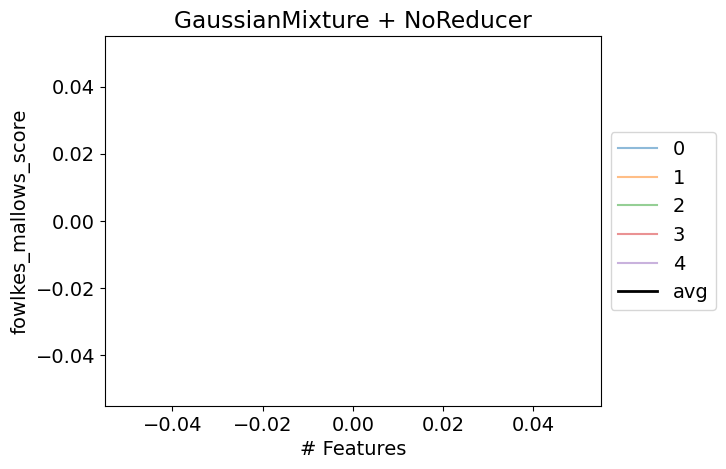

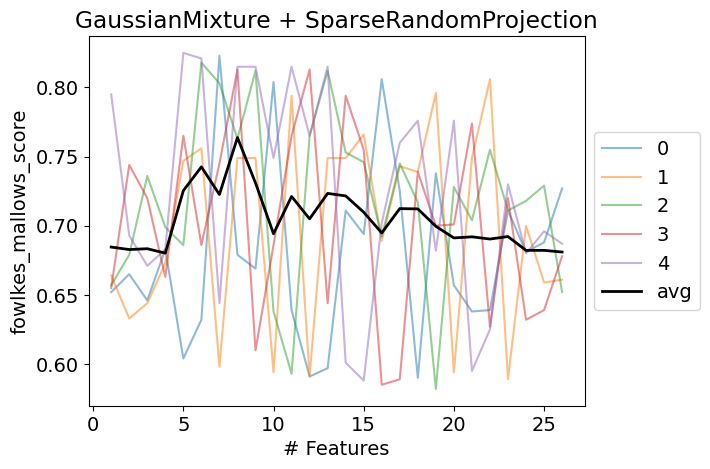

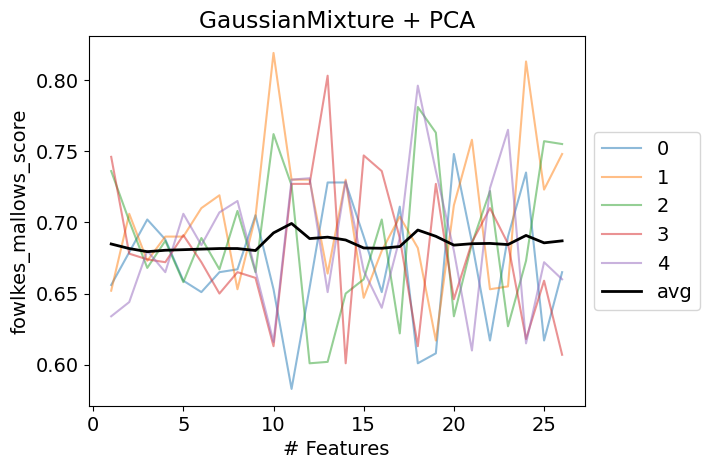

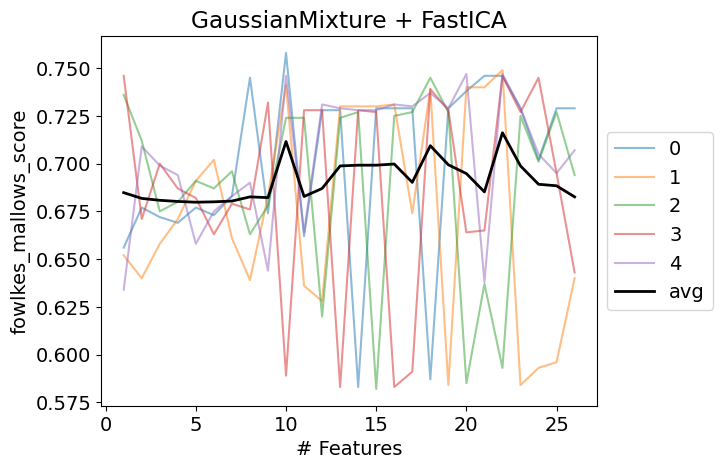

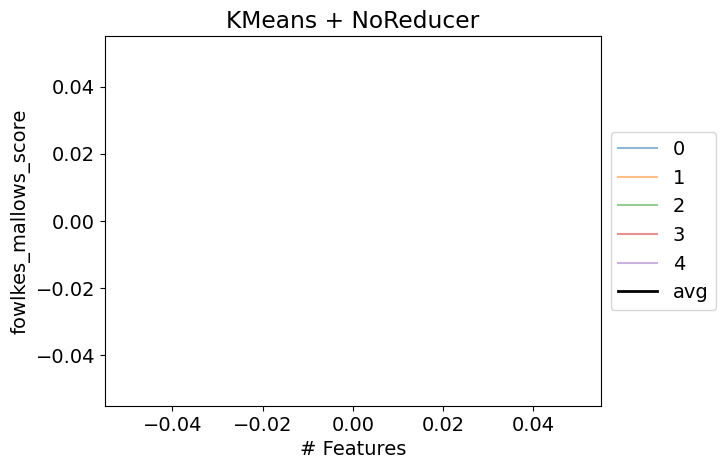

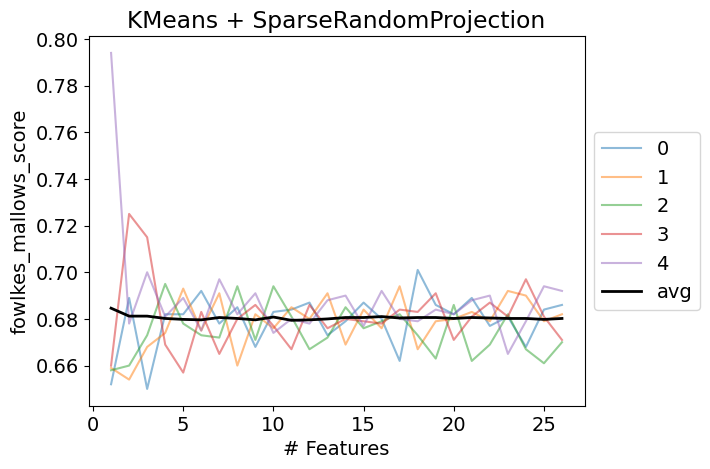

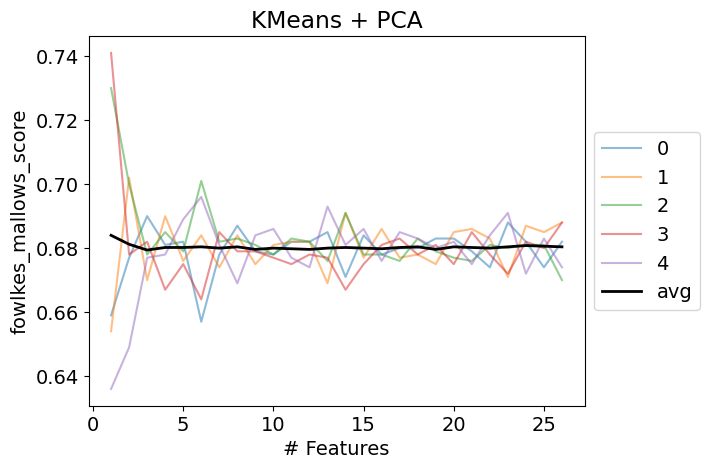

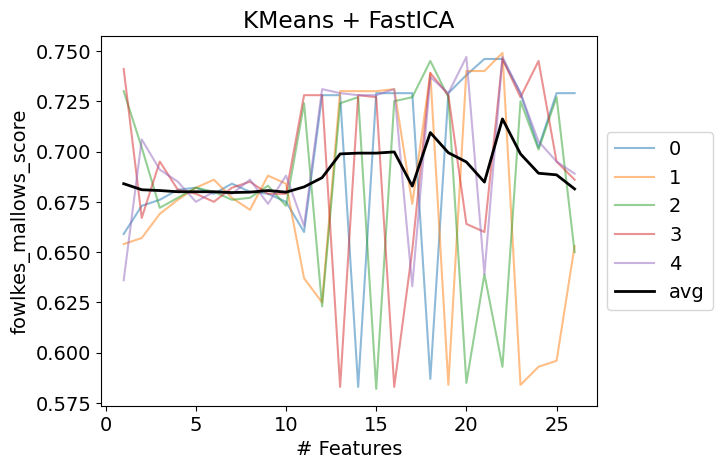

In [64]:
cancer_expr = {
    'reducers': [NoReducer, SparseRandomProjection, PCA, functools.partial(FastICA, tol=0.001)],
    'models': [GaussianMixture, KMeans],
    'n_components': range(1, cancer_inputs.shape[1]),
    'n_clusters': n_cancer_classes,
    'metric': fowlkes_mallows_score,
    'inputs': cancer_inputs,
    'targets': cancer_target,
    'filename': 'Cancer_UL_Naive.json',
    'reducer_args': {'random_state': 7},
    'clusterer_args': {'random_state': 7},
    'multiclass': True
}

cancer_results = get_experiment_results(**cancer_expr)
plot_results(cancer_expr, cancer_results)

# 4 - Bankruptcy

In [18]:
bankruptcy_data = DATA.get_bankruptcy_full()
bankruptcy_data.columns = [col.strip() for col in bankruptcy_data.columns]
bankruptcy_inputs = bankruptcy_data.drop('Bankrupt?', axis=1)
bankruptcy_inputs = apply_robust_scaler(bankruptcy_inputs)
bankruptcy_target = bankruptcy_data['Bankrupt?']
bankruptcy_interesting_cols = [
    'ROA(A) before interest and % after tax',
    'Persistent EPS in the Last Four Seasons',
    'Per Share Net profit before tax (Yuan ¥)',
    'Debt ratio %',
    'Net profit before tax/Paid-in capital',
    'Net Income to Total Assets'
]

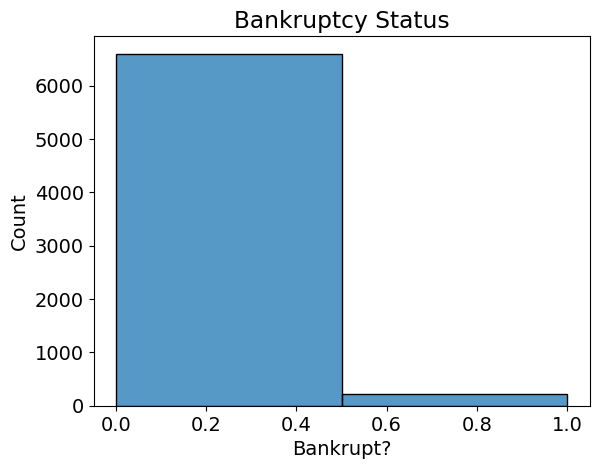

In [19]:
sns.histplot(bankruptcy_target, bins=2)
plt.title('Bankruptcy Status')
plt.show()

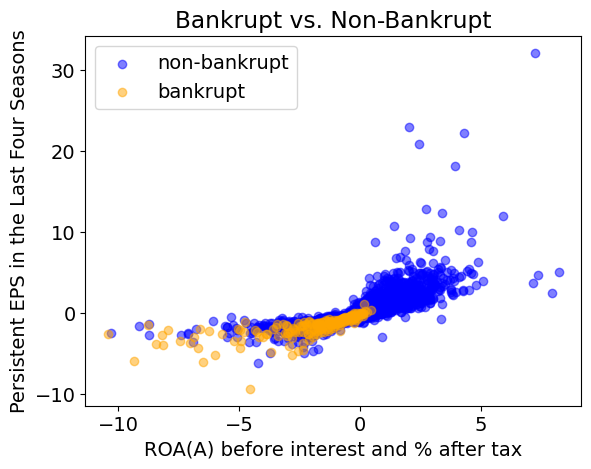

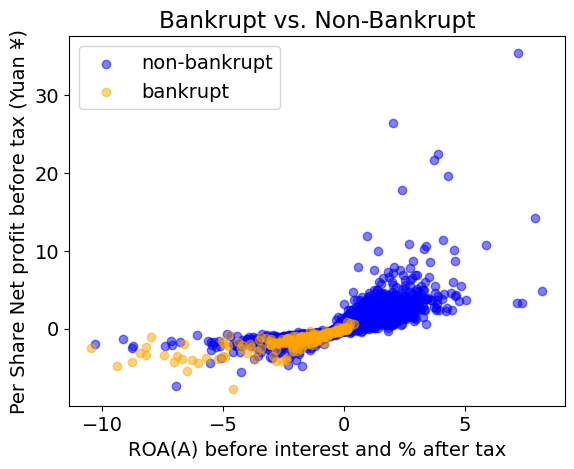

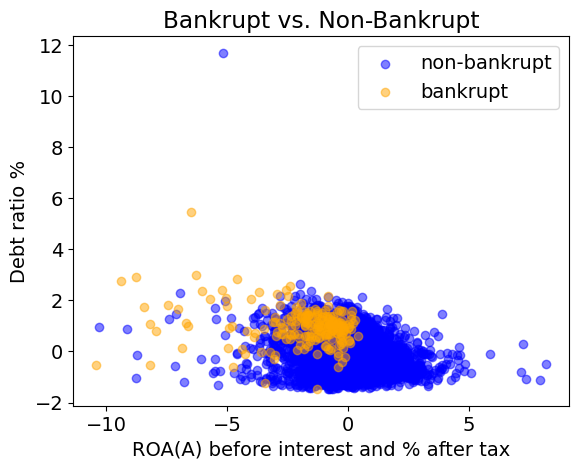

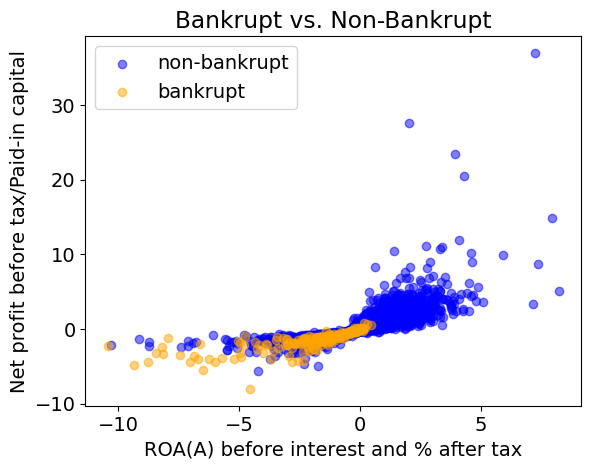

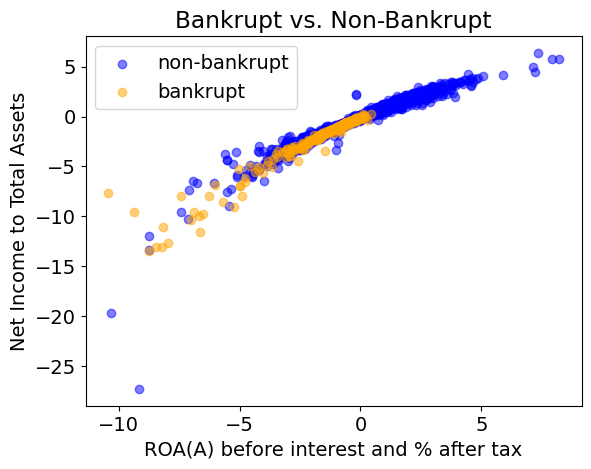

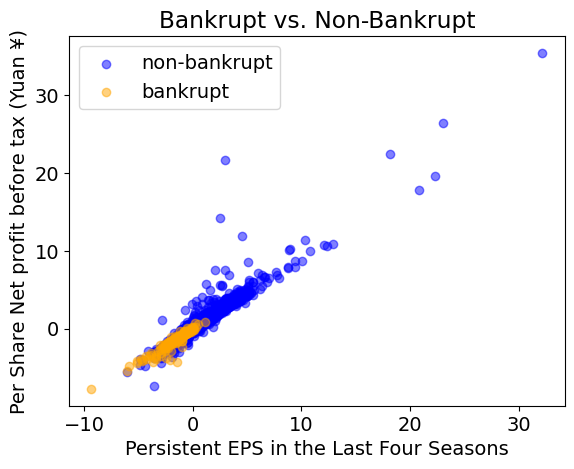

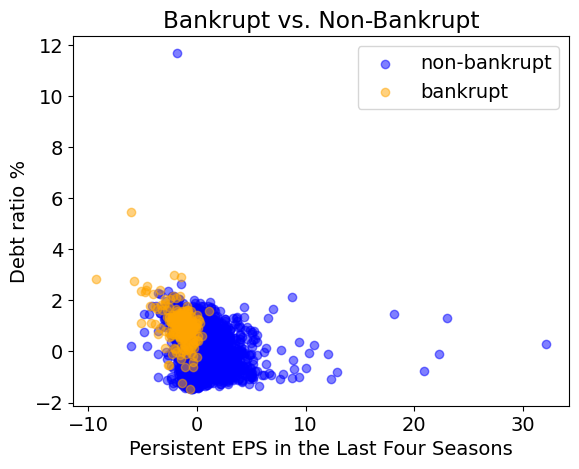

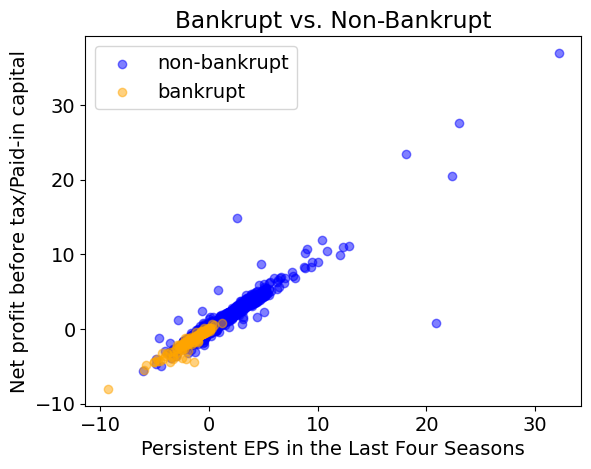

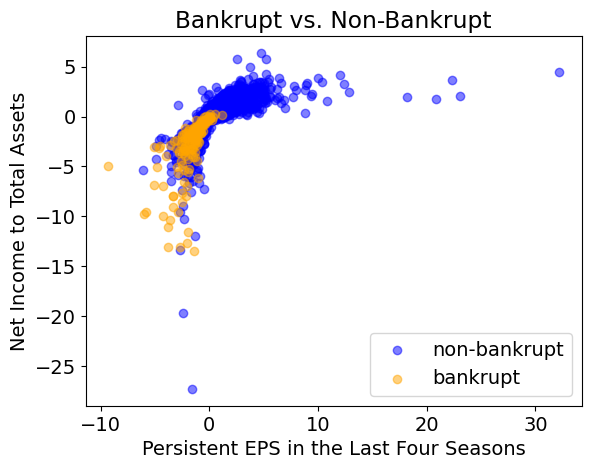

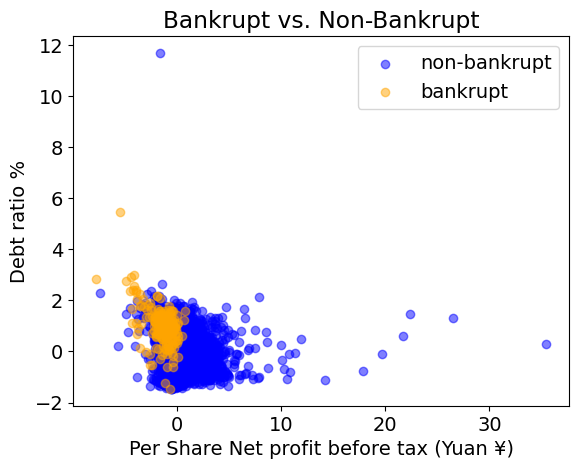

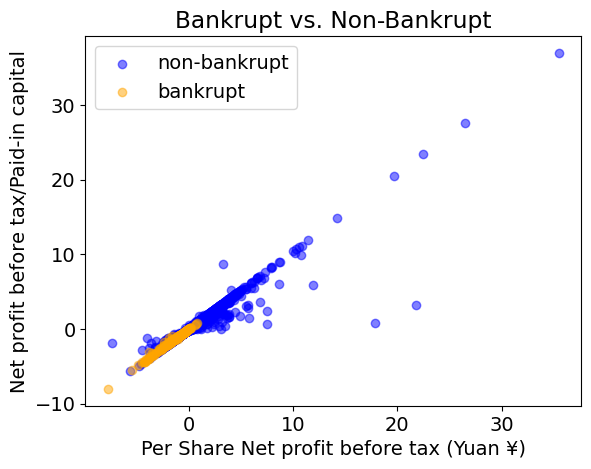

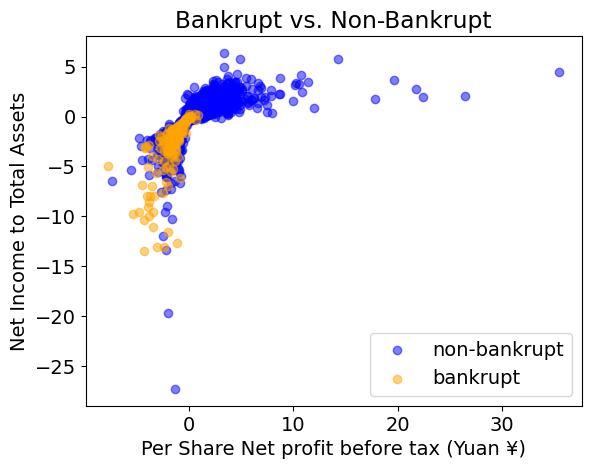

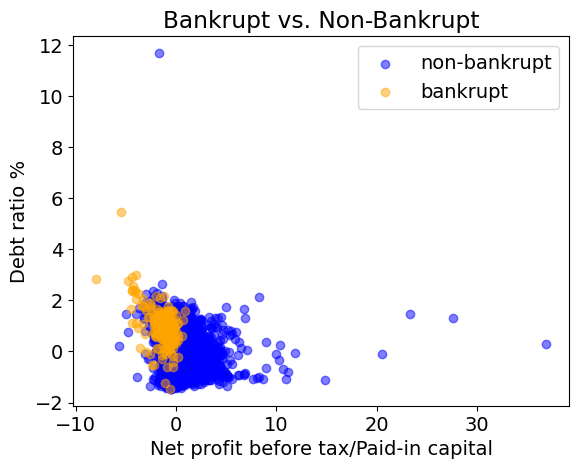

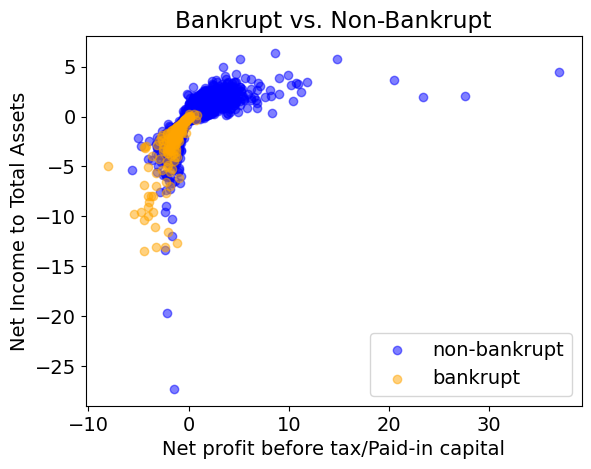

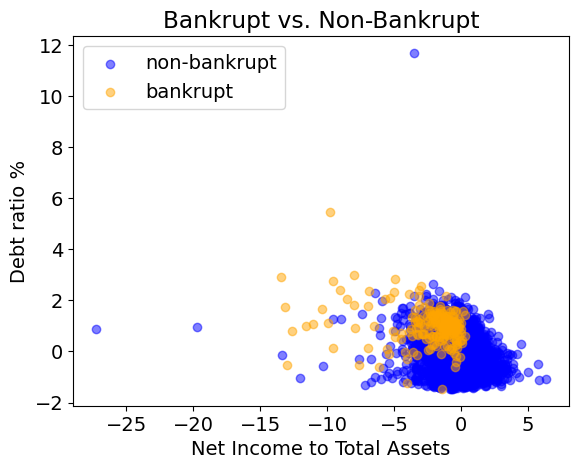

In [20]:
bankrupt_inputs = bankruptcy_inputs[bankruptcy_target==1]
nonbankrupt_inputs = bankruptcy_inputs[bankruptcy_target==0]

for icol in bankruptcy_interesting_cols:
    for jcol in bankruptcy_interesting_cols:
        if icol>jcol:
            plt.scatter(nonbankrupt_inputs[icol], nonbankrupt_inputs[jcol], label='non-bankrupt', color='blue', alpha=0.5)
            plt.scatter(bankrupt_inputs[icol], bankrupt_inputs[jcol], label='bankrupt', color='orange', alpha=0.5)
            plt.xlabel(icol)
            plt.ylabel(jcol)
            plt.legend()
            plt.title('Bankrupt vs. Non-Bankrupt')
            plt.show()

## 4.1 - Clustering

### 4.1.1 - EM

In [21]:
clust, pred, score = apply_clusterer(GaussianMixture, 2, bankruptcy_inputs, bankruptcy_target, fowlkes_mallows_score, covariance_type='spherical')
print('Score:', score)
# plot_according_to(bankruptcy_inputs, bankruptcy_interesting_cols, pred, sns.color_palette('tab10'))
log_cluster_results(bankruptcy_data[bankruptcy_interesting_cols], bankruptcy_target, pred, sns.color_palette('tab10'), 'Bankruptcy_EM_Clustering.pdf')

Score: 0.7009198108753424


### 4.1.2 - K-Means

In [22]:
clust, pred, score = apply_clusterer(KMeans, 2, bankruptcy_inputs, bankruptcy_target, fowlkes_mallows_score)
print('Score:', score)
# plot_according_to(bankruptcy_inputs, bankruptcy_interesting_cols, pred, sns.color_palette('tab10'))
log_cluster_results(bankruptcy_data[bankruptcy_interesting_cols], bankruptcy_target, pred, sns.color_palette('tab10'), 'Bankruptcy_KMeans_Clustering.pdf')

Score: 0.8381958979962952


## 4.2 - Linear Dimensionality Reduction

### 4.2.1 - Randomized Projections

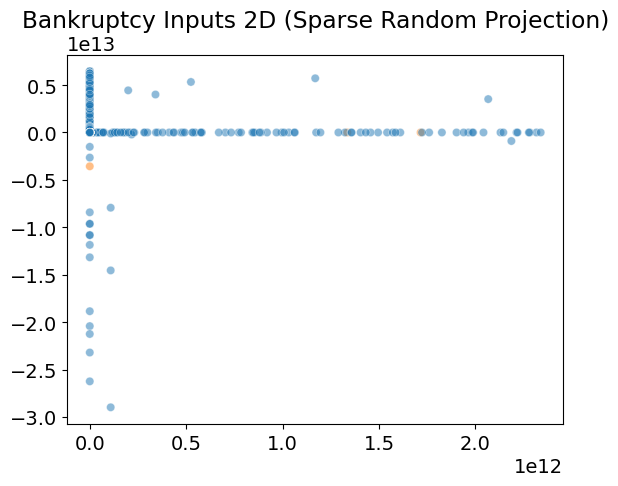

In [23]:
bankruptcy_inputs_sparse_2D = plot_2D(SparseRandomProjection, bankruptcy_inputs, 'Bankruptcy Inputs 2D (Sparse Random Projection)', bankruptcy_target, sns.color_palette('tab10'))

In [24]:
try:
    tmp = SparseRandomProjection(random_state=7).fit_transform(bankruptcy_inputs)
    print(tmp.shape[1])
except Exception as e:
    print(e)

eps=0.100000 and n_samples=6819 lead to a target dimension of 7566 which is larger than the original space with n_features=95


### 4.2.2 - PCA

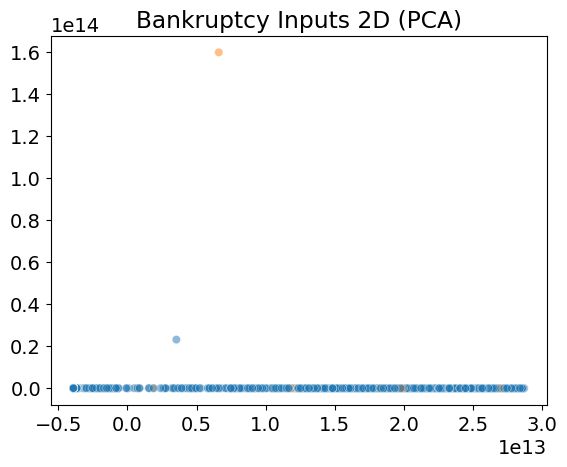

In [25]:
bankruptcy_inputs_PCA_2D = plot_2D(PCA, bankruptcy_inputs, 'Bankruptcy Inputs 2D (PCA)', bankruptcy_target, sns.color_palette('tab10'))

In [26]:
try:
    tmp = PCA(random_state=7).fit_transform(bankruptcy_inputs)
    print(tmp.shape[1])
except Exception as e:
    print(e)

95


### 4.2.3 - ICA

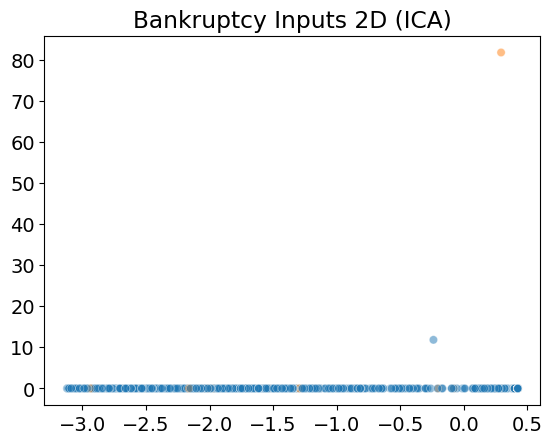

In [27]:
bankruptcy_inputs_ICA_2D = plot_2D(FastICA, bankruptcy_inputs, 'Bankruptcy Inputs 2D (ICA)', bankruptcy_target, sns.color_palette('tab10'))

## 4.3 - Experiments

In [29]:
for reducer in [NoReducer, BestColReducer]:
    reduced_inputs = reducer(best_cols=bankruptcy_interesting_cols).fit_transform(bankruptcy_inputs)
    for model in [GaussianMixture, KMeans]:
        if model == GaussianMixture:
            m = functools.partial(GaussianMixture, covariance_type='spherical')
        else:
            m = model
        preds = m(2, random_state=7).fit(reduced_inputs).predict(reduced_inputs)
        fm_score = round(fowlkes_mallows_score(bankruptcy_target, preds), 3)
        print(f'({reducer.__name__}, {model.__name__}) Class {i} Fowlkes-Mallows Score: {fm_score}')

(NoReducer, GaussianMixture) Class 1 Fowlkes-Mallows Score: 0.701
(NoReducer, KMeans) Class 1 Fowlkes-Mallows Score: 0.838
(BestColReducer, GaussianMixture) Class 1 Fowlkes-Mallows Score: 0.758
(BestColReducer, KMeans) Class 1 Fowlkes-Mallows Score: 0.746


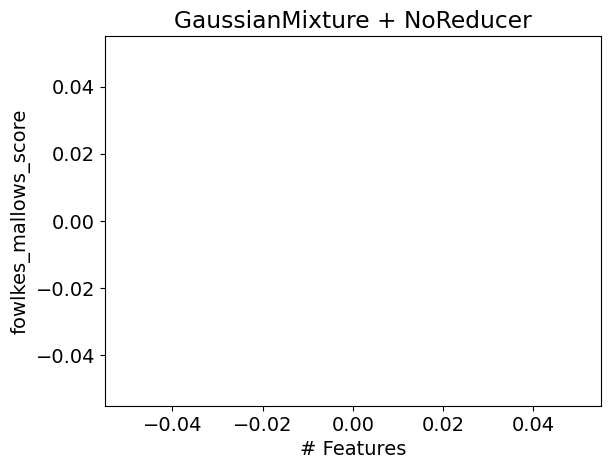

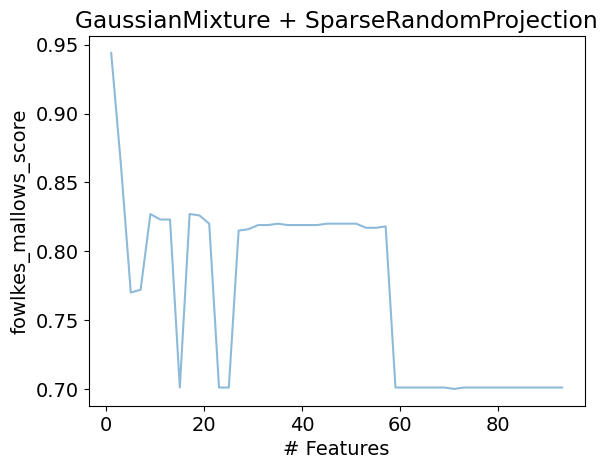

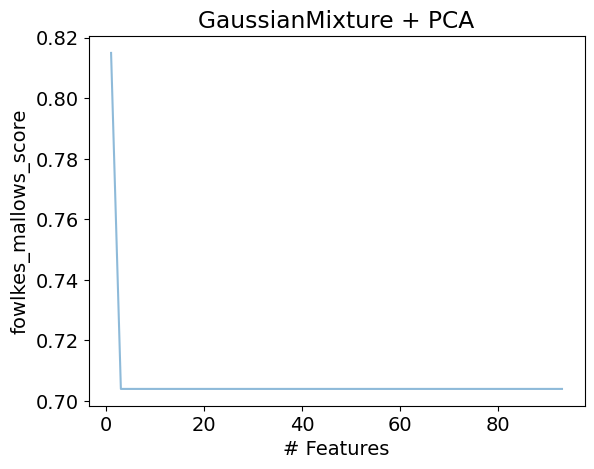

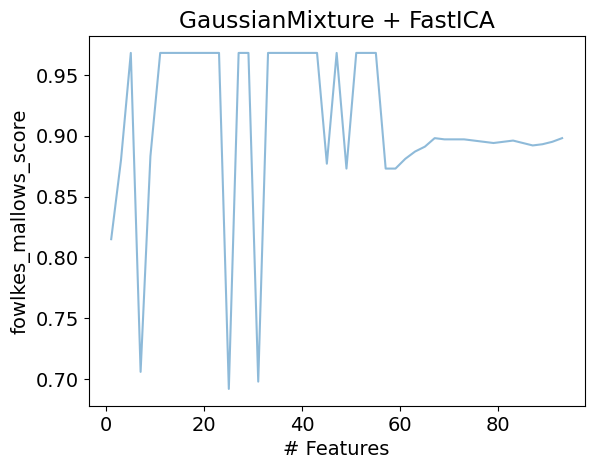

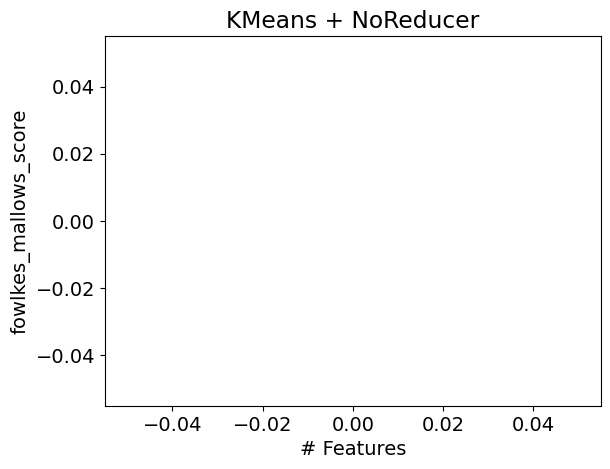

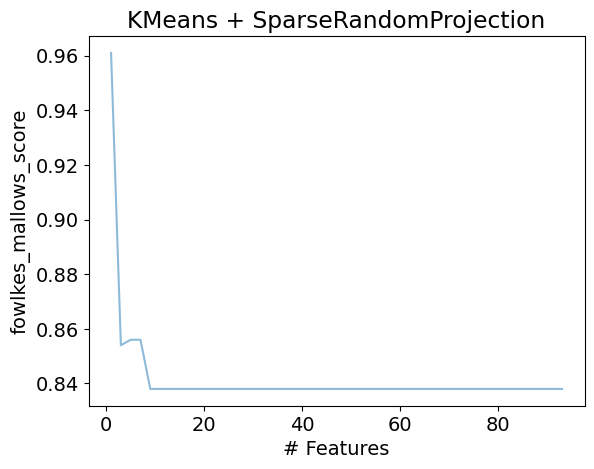

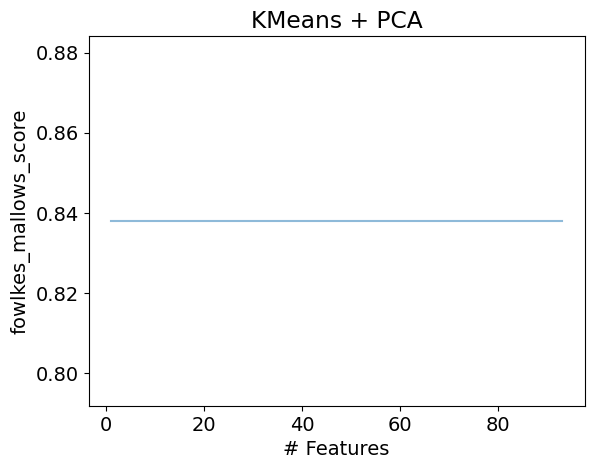

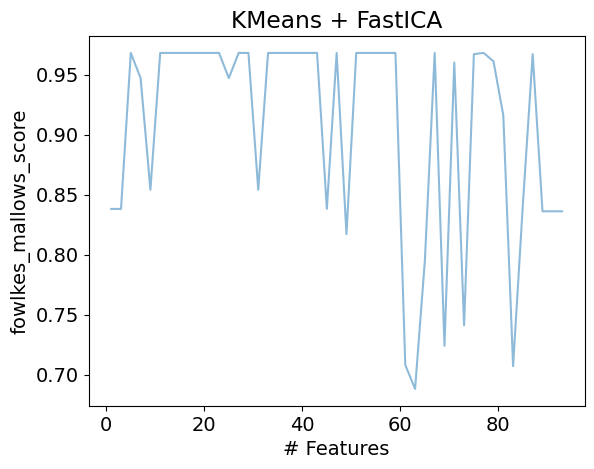

In [30]:
bankruptcy_expr = {
    'reducers': [NoReducer, SparseRandomProjection, PCA, functools.partial(FastICA, tol=0.05)],
    'models': [functools.partial(GaussianMixture, covariance_type='spherical'), KMeans],
    'n_components': range(1, bankruptcy_inputs.shape[1], 2),
    'n_clusters': 2,
    'metric': fowlkes_mallows_score,
    'inputs': bankruptcy_inputs,
    'targets': bankruptcy_target,
    'filename': 'Bankruptcy_UL_Naive.json',
    'reducer_args': {'random_state': 7},
    'clusterer_args': {'random_state': 7},
    'multiclass': False
}

bankruptcy_results = get_experiment_results(**bankruptcy_expr)
plot_results(bankruptcy_expr, bankruptcy_results)

# 5 - SL Comparison

In [ ]:
comparison_data = DATA.get_bankruptcy_full()
comparison_data.columns = [col.strip() for col in comparison_data.columns]  # clean up messy column names
target_col = 'Bankrupt?'
comparison_target = comparison_data[target_col]
comparison_inputs = comparison_data.drop(target_col, axis=1)
comparison_inputs = apply_robust_scaler(comparison_inputs)

# only use so many non-bankrupt samples to more closely "balance" the dataset (now 25% bankrupt vs 3.23%)
comparison0 = comparison_inputs[comparison_target==0]
comparison1 = comparison_inputs[comparison_target==1]
train_indices = comparison0.sample(comparison1.shape[0]*3).index
comparison_inputs = pd.concat([comparison0.loc[train_indices], comparison1])
comparison_target = pd.concat([comparison_target.loc[train_indices], comparison_target[comparison_target==1]])

# free up memory
del comparison0
del comparison1

# cX_train, cX_test, cy_train, cy_test = train_test_split(
#     comparison_inputs,
#     comparison_target,
#     shuffle=True,
#     random_state=7,
#     test_size=0.25,  # just a little bit, we want most for CV,
#     stratify=comparison_target  # split evenly by class
#     )

# # add discarded data to test set
# # cX_test = pd.concat([comparison_data.drop('Bankrupt?', axis=1).drop(train_indices, axis=0), cX_test])
# # cy_test = pd.concat([comparison_data['Bankrupt?'].drop(train_indices, axis=0), cy_test])

# # load best model
# with open(f'{DATA.root}logs/{SL_RESULTS_NAME}/Bankruptcy_NN_Logistic.json', 'r') as file:
#     sl_results = json.load(file)
# best_params = sorted(sl_results, key=lambda cv_result: cv_result['test_score'])[-1]['params']
# model = MLPClassifier(random_state=7, **best_params)

# # dimensionality reduction steps
# best_sl_cols = [
#     'ROA(A) before interest and % after tax',
#     'Persistent EPS in the Last Four Seasons',
#     'Per Share Net profit before tax (Yuan ¥)',
#     'Debt ratio %',
#     'Net profit before tax/Paid-in capital',
#     'Net Income to Total Assets'
# ]

# comparison_expr = {
#     'reducers': [
#         NoReducer, 
#         functools.partial(BestColReducer, best_cols=best_sl_cols), 
#         SparseRandomProjection, 
#         PCA, 
#         functools.partial(FastICA, tol=0.05)
#     ],
#     'n_components': range(1, cX_train.shape[1]),
#     'metric': f1_score,
#     'X': {'train': cX_train, 'test': cX_test},
#     'y': {'train': cy_train, 'test': cy_test},
#     'filename': 'Bankruptcy_SL_DimRed_Perf.json',
#     'model': model,
#     'reducer_args': {'random_state': 7},
# }

# print(sorted(sl_results, key=lambda cv_result: cv_result['test_score'])[-1])
# comparison_results = sl_experiment(**comparison_expr)
# plot_results(comparison_expr, comparison_results)

In [77]:
test = np.array([[0,0,0], [1,1,1], [2,2,2]])
for i in range(test.shape[1]):
    print(test[:,i])

[0 1 2]
[0 1 2]
[0 1 2]


 40%|████      | 2/5 [00:04<00:06,  2.05s/it]

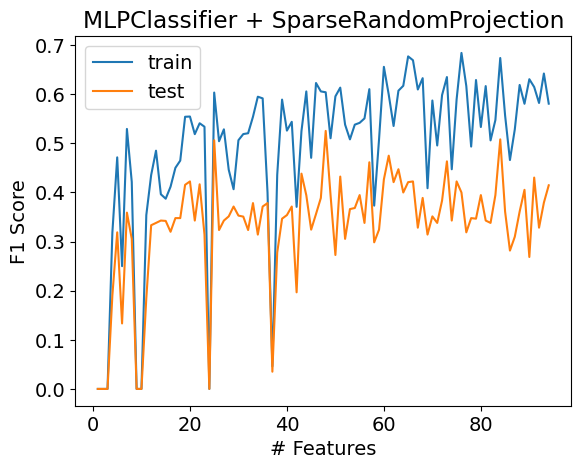

 60%|██████    | 3/5 [07:56<07:12, 216.43s/it]

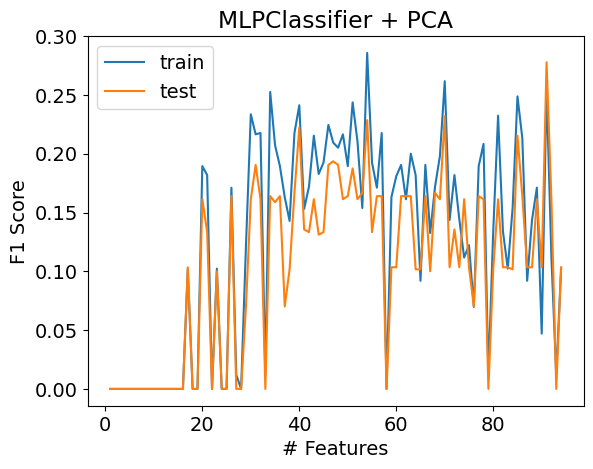

 80%|████████  | 4/5 [13:48<04:30, 270.27s/it]c:\Python312\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the m

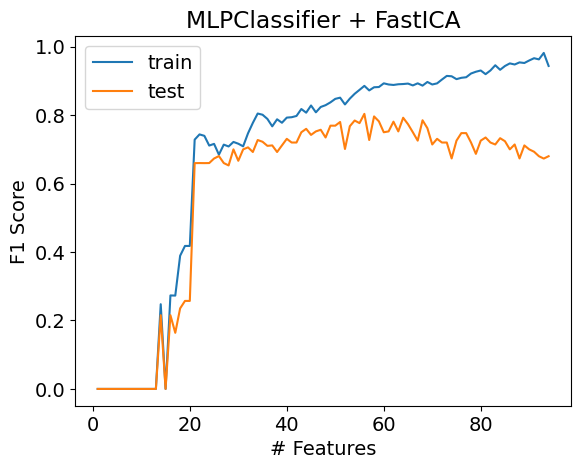

100%|██████████| 5/5 [24:21<00:00, 292.37s/it]


In [78]:
nn_params = {'activation': 'logistic', 'alpha': 0.001, 'solver': 'adam'}
reducers = [NoReducer, BestColReducer, SparseRandomProjection, PCA, FastICA]

X_train, X_test, y_train, y_test = train_test_split(
    comparison_inputs,
    comparison_target,
    shuffle=True,
    random_state=7,
    test_size=0.25,  # just a little bit, we want most for CV,
    stratify=comparison_target  # split evenly by class
)

if not os.path.exists(f'{DATA.root}logs/{EXPERIMENT_NAME}/sl_dimred2.json'):
    results = []
    for reducer in tqdm(reducers):
        if reducer == FastICA:
            red = functools.partial(FastICA, tol=0.05, max_iter=300)
        else:
            red = reducer
        red_results = []
        for n in range(1, comparison_inputs.shape[1]):
            if reducer == NoReducer:
                rX_train, rX_test = X_train, X_test
            elif reducer == BestColReducer:
                rX_train, rX_test = X_train[bankruptcy_interesting_cols], X_test[bankruptcy_interesting_cols]
            else:
                r = red(n, random_state=7)
                r.fit(X_train)
                rX_train, rX_test = r.transform(X_train), r.transform(X_test)
            tmp_best_nn_params = nn_params
            tmp_best_nn_params['hidden_layer_sizes'] = [2*rX_train.shape[1]]*3
            model = MLPClassifier(random_state=7, **tmp_best_nn_params).fit(rX_train, y_train)
            test_score = f1_score(y_test, model.predict(rX_test))
            train_score = f1_score(y_train, model.predict(rX_train))
            red_results.append({
                'reducer': reducer.__name__,
                'model': MLPClassifier.__name__,
                'n_components': rX_train.shape[1],
                'test_score': test_score,
                'train_score': train_score,
                'score': test_score,  # for integration into later functions
                'metric': 'f1_score'
            })
            if reducer == NoReducer or reducer == BestColReducer:
                break
        results += red_results
        if reducer not in [NoReducer, BestColReducer]:
            plt.plot(range(1, comparison_inputs.shape[1]), [r['train_score'] for r in red_results], label='train')
            plt.plot(range(1, comparison_inputs.shape[1]), [r['test_score'] for r in red_results], label='test')
            plt.xlabel('# Features')
            plt.ylabel('F1 Score')
            plt.title(f'MLPClassifier + {reducer.__name__}')
            plt.legend()
            plt.show()
    with open(f'{DATA.root}logs/{EXPERIMENT_NAME}/sl_dimred2.json', 'w+') as file:
        json.dump(results, file)


# 6 - Inspection of Most Performant Results

Comparing results via the Fowlkes-Mallows Score. Tiebreaking is won by whichever result has fewer features.

In [66]:
files = [
    'sl_dimred2.json',
    'Bankruptcy_UL_Naive.json',
    'Cancer_UL_Naive.json'
]

for file in files:
    # print(file)
    filepath = f'{DATA.root}logs/{EXPERIMENT_NAME}/{file}'
    with open(filepath, 'r') as f:
        results = json.load(f)
    for model in [MLPClassifier, GaussianMixture, KMeans]:
        if model == MLPClassifier:
            model_results = [r for r in results if r['model']==model.__name__ and r['metric']=='f1_score']
        else:
            model_results = [r for r in results if r['model']==model.__name__ and r['metric']=='fowlkes_mallows_score']
            # print(len(model_results))
        for reducer in [functools.partial(BestColReducer, best_cols=best_sl_cols), 
                        SparseRandomProjection, PCA, functools.partial(FastICA, tol=0.05)]:
            if reducer.__class__.__name__ == 'partial':
                reducer_name = reducer.func.__name__
            else:
                reducer_name = reducer.__name__
            tmp_results = [r for r in model_results if r['reducer']==reducer_name]
            if tmp_results:
                # finding best results this way to break ties
                if 'target_class' in tmp_results[0]:
                    classes = list(set([r['target_class'] for r in tmp_results]))
                    n_components = sorted(list(set([r['n_components'] for r in tmp_results])))
                    class_averages = []
                    for nc in n_components:
                        class_averages.append(np.mean([r['score'] for r in tmp_results if r['n_components']==nc]))
                    for i in range(len(tmp_results)):
                        tmp_results[i]['score'] = class_averages[n_components.index(tmp_results[i]['n_components'])]
                best_score = sorted(tmp_results, key=lambda r: r['score'])[-1]['score']
                best_result = sorted([r for r in tmp_results if r['score']==best_score], key=lambda r: r['n_components'])[0]
                m = model
                if 'Cancer' in file:
                    data = cancer_inputs
                    target = cancer_target
                    data_name = 'Cancer'
                    n_classes = n_cancer_classes
                else:
                    data = bankruptcy_inputs
                    target = bankruptcy_target
                    data_name = 'Bankruptcy'
                    n_classes = 2
                    if m == GaussianMixture:
                        m = functools.partial(GaussianMixture, covariance_type='spherical')
                log_as = f'BEST_{data_name}_{reducer_name}_{model.__name__}.pdf'
                print(log_as)
                print(best_result)
                if not os.path.exists(f'{DATA.root}logs/{EXPERIMENT_NAME}/{log_as}'):
                    data = pd.DataFrame(reducer(n_components=best_result['n_components'], random_state=7).fit_transform(data))
                    if best_result['n_components'] >= 31:  # arbitrary cutoff to sample half
                        data = data[data.columns[::2]]
                    m = m(n_classes, random_state=7).fit(data, target)
                    preds = m.predict(data)
                    log_cluster_results(
                        data, 
                        target, 
                        preds, 
                        sns.color_palette('tab10'), 
                        log_as
                    )

BEST_Bankruptcy_BestColReducer_MLPClassifier.pdf
{'reducer': 'BestColReducer', 'model': 'MLPClassifier', 'n_components': 6, 'test_score': 0.780952380952381, 'train_score': 0.7333333333333333, 'score': 0.780952380952381, 'metric': 'f1_score'}
BEST_Bankruptcy_SparseRandomProjection_MLPClassifier.pdf
{'reducer': 'SparseRandomProjection', 'model': 'MLPClassifier', 'n_components': 48, 'test_score': 0.5254237288135594, 'train_score': 0.6041055718475073, 'score': 0.5254237288135594, 'metric': 'f1_score'}
BEST_Bankruptcy_PCA_MLPClassifier.pdf
{'reducer': 'PCA', 'model': 'MLPClassifier', 'n_components': 91, 'test_score': 0.2777777777777778, 'train_score': 0.2557077625570776, 'score': 0.2777777777777778, 'metric': 'f1_score'}
BEST_Bankruptcy_FastICA_MLPClassifier.pdf
{'reducer': 'FastICA', 'model': 'MLPClassifier', 'n_components': 56, 'test_score': 0.8037383177570093, 'train_score': 0.8855421686746988, 'score': 0.8037383177570093, 'metric': 'f1_score'}
BEST_Bankruptcy_SparseRandomProjection_Gaus

100%|██████████| 28/28 [02:40<00:00,  5.74s/it]


BEST_Cancer_PCA_GaussianMixture.pdf
{'reducer': 'PCA', 'model': 'GaussianMixture', 'metric': 'fowlkes_mallows_score', 'score': np.float64(0.6991999999999999), 'n_components': 11, 'n_clusters': 5, 'target_class': 0}


100%|██████████| 55/55 [07:12<00:00,  7.87s/it]


BEST_Cancer_FastICA_GaussianMixture.pdf
{'reducer': 'FastICA', 'model': 'GaussianMixture', 'metric': 'fowlkes_mallows_score', 'score': np.float64(0.7162), 'n_components': 22, 'n_clusters': 5, 'target_class': 0}


100%|██████████| 231/231 [32:44<00:00,  8.51s/it]


BEST_Cancer_SparseRandomProjection_KMeans.pdf
{'reducer': 'SparseRandomProjection', 'model': 'KMeans', 'metric': 'fowlkes_mallows_score', 'score': np.float64(0.6846), 'n_components': 1, 'n_clusters': 5, 'target_class': 0}
BEST_Cancer_PCA_KMeans.pdf
{'reducer': 'PCA', 'model': 'KMeans', 'metric': 'fowlkes_mallows_score', 'score': np.float64(0.684), 'n_components': 1, 'n_clusters': 5, 'target_class': 0}
BEST_Cancer_FastICA_KMeans.pdf
{'reducer': 'FastICA', 'model': 'KMeans', 'metric': 'fowlkes_mallows_score', 'score': np.float64(0.7162), 'n_components': 22, 'n_clusters': 5, 'target_class': 0}


100%|██████████| 231/231 [29:19<00:00,  7.61s/it] 


# 7 - Clustering Behavior

Describe "niceness" of each "best" cluster with silhouette score. Are the clusters that are the most performant at capturing the target class also the best by silhouette score?

In [34]:
inputs = ['cancer', 'bankruptcy']
models = [GaussianMixture, KMeans]
reducers = [NoReducer, BestColReducer, SparseRandomProjection, PCA, FastICA]
results = []

if not os.path.exists(f'{DATA.root}logs/{EXPERIMENT_NAME}/silhouette_scores.json'):
    for input_name, model, reducer in tqdm(itertools.product(inputs, models, reducers), total=len(inputs)*len(models)*len(reducers)):
        # data
        if input_name == 'cancer':
            data = cancer_inputs
            target = cancer_target
            n_clusters = 5
        elif input_name == 'bankruptcy':
            data = bankruptcy_inputs
            target = bankruptcy_target
            n_clusters = 2

        # model special case
        if input_name == 'bankruptcy' and model == GaussianMixture:
            tmp_model = functools.partial(GaussianMixture, covariance_type='spherical')
        else:
            tmp_model = model

        # reducer special case(s)
        if reducer in [NoReducer, BestColReducer]:
            if input_name == 'cancer' and reducer == BestColReducer:
                tmp_reducer = functools.partial(BestColReducer, best_cols=cancer_inputs.columns)
            elif input_name == 'bankruptcy' and reducer == BestColReducer:
                tmp_reducer = functools.partial(BestColReducer, best_cols=best_sl_cols)
            else:
                tmp_reducer = reducer
        elif reducer == FastICA:
            tmp_reducer = functools.partial(FastICA, tol=0.05)
        else:
            tmp_reducer = reducer
        
        # best result special case(s)
        if reducer in [NoReducer, BestColReducer]:
            reduced_data = tmp_reducer().fit_transform(data)
            score = silhouette_score(reduced_data, tmp_model(n_clusters, random_state=7).fit_predict(reduced_data)) 
            results.append({
                'data': input_name,
                'reducer': reducer.__name__,
                'model': model.__name__,
                'n_features': reduced_data.shape[1],
                'silhouette_score': score
            })
        else:
            for n_features in tqdm(range(1, data.shape[1]), leave=False):
                reduced_data = tmp_reducer(n_features, random_state=7).fit_transform(data)
                score = silhouette_score(reduced_data, tmp_model(n_clusters, random_state=7).fit_predict(reduced_data)) 
                results.append({
                    'data': input_name,
                    'reducer': reducer.__name__,
                    'model': model.__name__,
                    'n_features': reduced_data.shape[1],
                    'silhouette_score': score
                })
    with open(f'{DATA.root}logs/{EXPERIMENT_NAME}/silhouette_scores.json', 'w+') as file:
        json.dump(results, file)
else:
    with open(f'{DATA.root}logs/{EXPERIMENT_NAME}/silhouette_scores.json', 'r') as file:
        results = json.load(file)


In [69]:
fowlkes_mallows_score([0,1,1,0,1,1,1,1], [1,1,1,1,1,1,1,0])

np.float64(0.600099198148979)

{'data': 'cancer', 'reducer': 'NoReducer', 'model': 'GaussianMixture', 'n_features': 27, 'silhouette_score': 0.01817837734365577}
{'data': 'cancer', 'reducer': 'NoReducer', 'model': 'KMeans', 'n_features': 27, 'silhouette_score': 0.05383774125492104}
{'data': 'cancer', 'reducer': 'BestColReducer', 'model': 'GaussianMixture', 'n_features': 27, 'silhouette_score': 0.01817837734365577}
{'data': 'cancer', 'reducer': 'BestColReducer', 'model': 'KMeans', 'n_features': 27, 'silhouette_score': 0.05383774125492104}
{'data': 'cancer', 'reducer': 'SparseRandomProjection', 'model': 'GaussianMixture', 'n_features': 1, 'silhouette_score': 0.5695335824327867}


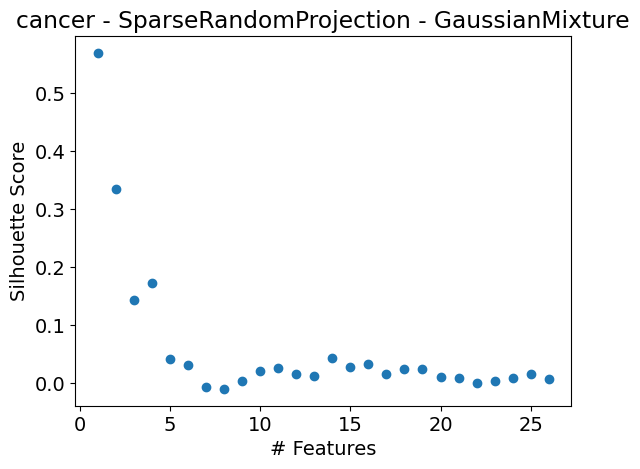

{'data': 'cancer', 'reducer': 'SparseRandomProjection', 'model': 'KMeans', 'n_features': 1, 'silhouette_score': 0.5704178719445666}


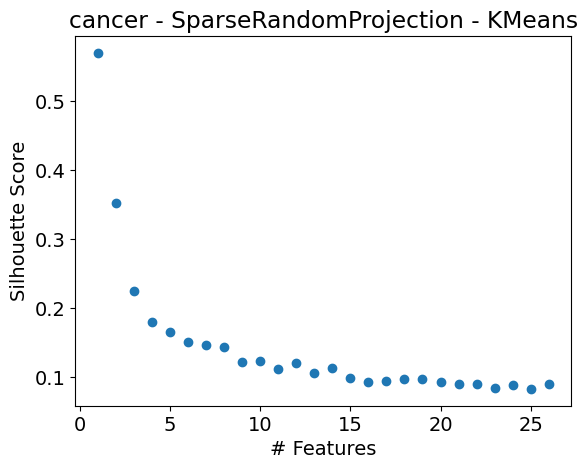

{'data': 'cancer', 'reducer': 'PCA', 'model': 'GaussianMixture', 'n_features': 1, 'silhouette_score': 0.5215921480158623}


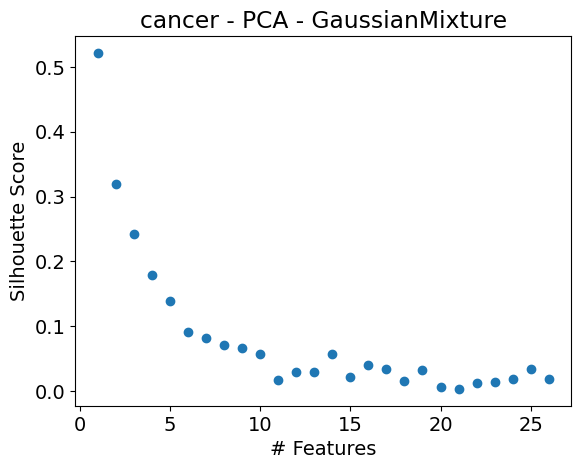

{'data': 'cancer', 'reducer': 'PCA', 'model': 'KMeans', 'n_features': 1, 'silhouette_score': 0.521697570286618}


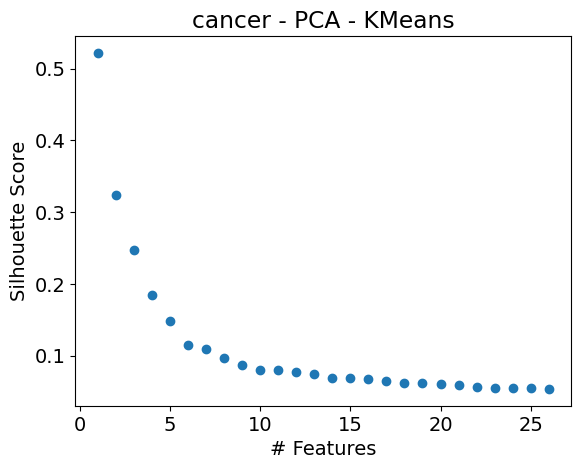

{'data': 'cancer', 'reducer': 'FastICA', 'model': 'GaussianMixture', 'n_features': 1, 'silhouette_score': 0.5215921480158618}


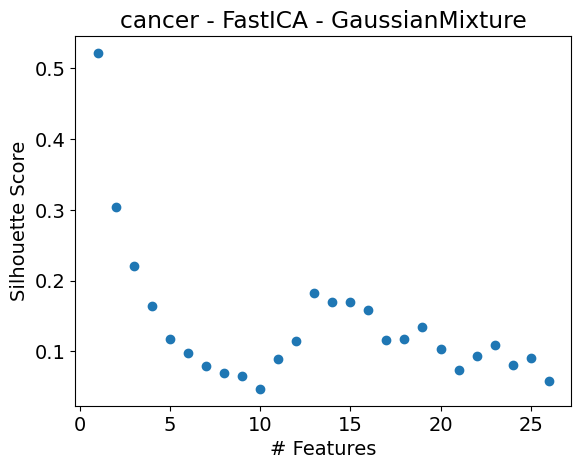

{'data': 'cancer', 'reducer': 'FastICA', 'model': 'KMeans', 'n_features': 1, 'silhouette_score': 0.5216975702866176}


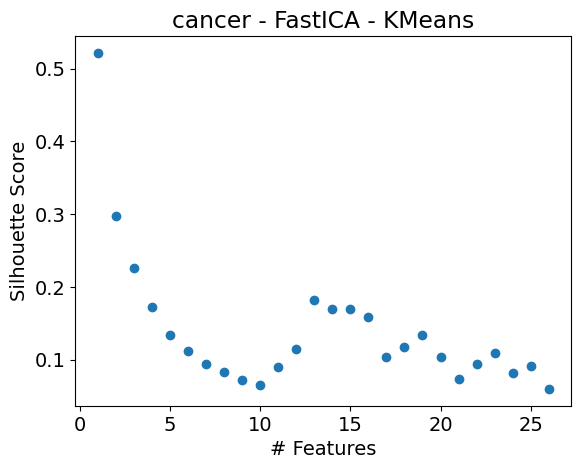

{'data': 'bankruptcy', 'reducer': 'NoReducer', 'model': 'GaussianMixture', 'n_features': 95, 'silhouette_score': 0.42771146570963453}
{'data': 'bankruptcy', 'reducer': 'NoReducer', 'model': 'KMeans', 'n_features': 95, 'silhouette_score': 0.9217811221966438}
{'data': 'bankruptcy', 'reducer': 'BestColReducer', 'model': 'GaussianMixture', 'n_features': 6, 'silhouette_score': 0.39382945832676586}
{'data': 'bankruptcy', 'reducer': 'BestColReducer', 'model': 'KMeans', 'n_features': 6, 'silhouette_score': 0.4505111718954265}
{'data': 'bankruptcy', 'reducer': 'SparseRandomProjection', 'model': 'GaussianMixture', 'n_features': 1, 'silhouette_score': 0.9634780384444561}


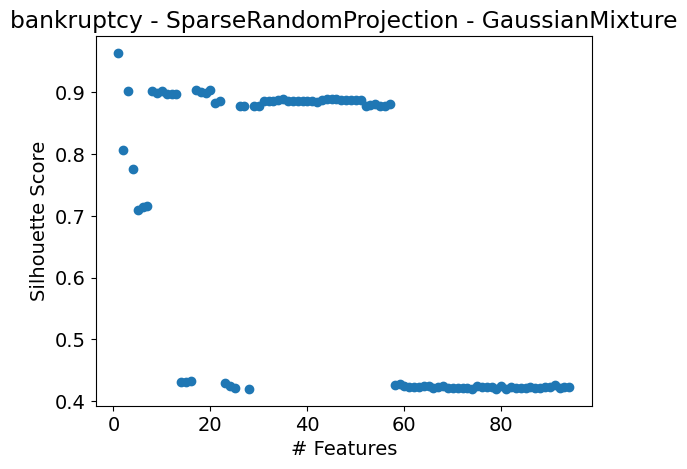

{'data': 'bankruptcy', 'reducer': 'SparseRandomProjection', 'model': 'KMeans', 'n_features': 1, 'silhouette_score': 0.9934076997218716}


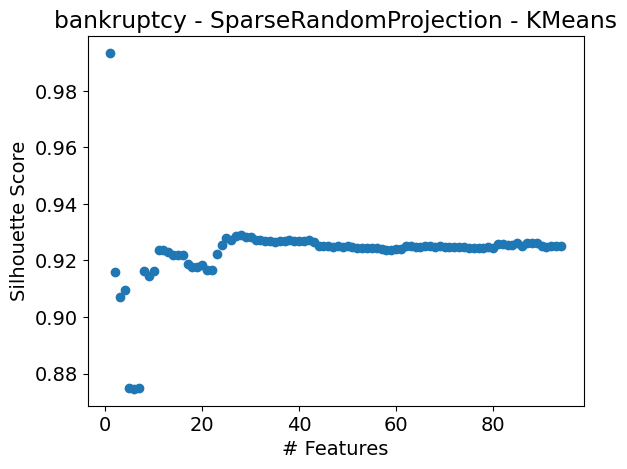

{'data': 'bankruptcy', 'reducer': 'PCA', 'model': 'GaussianMixture', 'n_features': 1, 'silhouette_score': 0.8923421144354194}


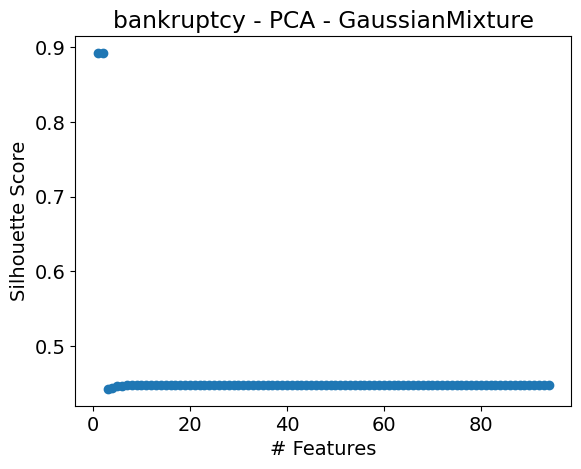

{'data': 'bankruptcy', 'reducer': 'PCA', 'model': 'KMeans', 'n_features': 1, 'silhouette_score': 0.945887028508526}


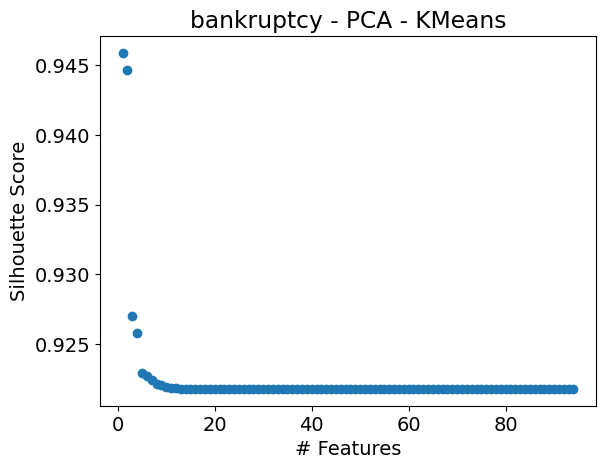

{'data': 'bankruptcy', 'reducer': 'FastICA', 'model': 'GaussianMixture', 'n_features': 5, 'silhouette_score': 0.9793207494002182}


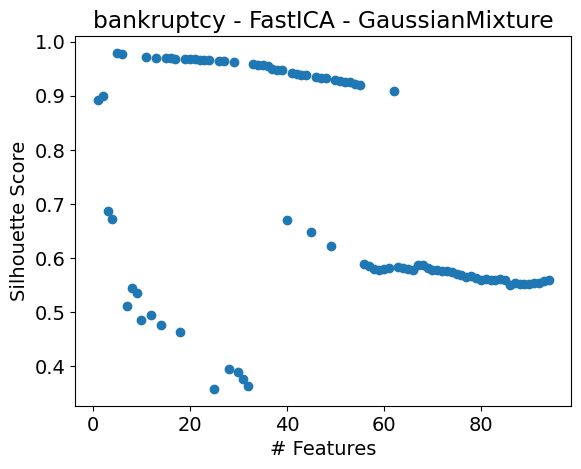

{'data': 'bankruptcy', 'reducer': 'FastICA', 'model': 'KMeans', 'n_features': 5, 'silhouette_score': 0.9793207494002182}


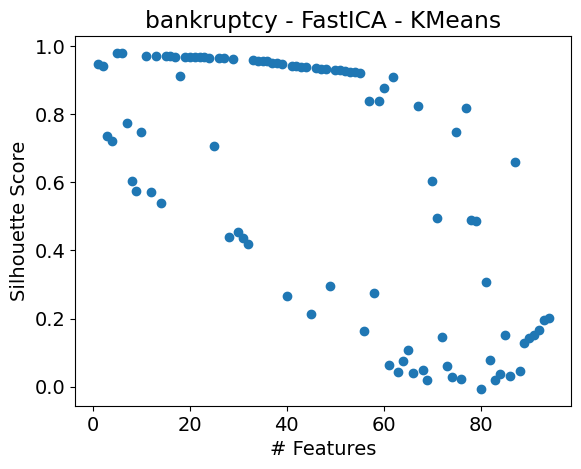

In [35]:
for data in ['cancer', 'bankruptcy']:
    for reducer in [NoReducer, BestColReducer, SparseRandomProjection, PCA, FastICA]:
        for model in [GaussianMixture, KMeans]:
            conditions = [
                lambda r: r['data'] == data,
                lambda r: r['reducer'] == reducer.__name__,
                lambda r: r['model'] == model.__name__
            ]
            tmp_results = [r for r in results if all([c(r) for c in conditions])]
            best_result = sorted(tmp_results, key=lambda r: r['silhouette_score'])[-1]
            print(best_result)
            if len(tmp_results) > 1:
                plt.scatter([r['n_features'] for r in tmp_results], [r['silhouette_score'] for r in tmp_results])
                plt.xlabel('# Features')
                plt.ylabel('Silhouette Score')
                plt.title(f'{data} - {reducer.__name__} - {model.__name__}')
                plt.show()

# 8 - Optimal Number of Clusters

In [36]:
# inputs = ['cancer', 'bankruptcy']
# models = [GaussianMixture, KMeans]
# reducers = [NoReducer, BestColReducer, SparseRandomProjection, PCA, FastICA]
# results = []

# if not os.path.exists(f'{DATA.root}logs/{EXPERIMENT_NAME}/best_silhouettes.json'):
#     for input_name, model, reducer in tqdm(itertools.product(inputs, models, reducers), total=len(inputs)*len(models)*len(reducers)):
#         # data
#         if input_name == 'cancer':
#             data = cancer_inputs
#             target = cancer_target
#         elif input_name == 'bankruptcy':
#             data = bankruptcy_inputs
#             target = bankruptcy_target

#         # model special case
#         if input_name == 'bankruptcy' and model == GaussianMixture:
#             tmp_model = functools.partial(GaussianMixture, covariance_type='spherical')
#         else:
#             tmp_model = model

#         # reducer special case(s)
#         if reducer in [NoReducer, BestColReducer]:
#             if input_name == 'cancer' and reducer == BestColReducer:
#                 tmp_reducer = functools.partial(BestColReducer, best_cols=cancer_inputs.columns)
#             elif input_name == 'bankruptcy' and reducer == BestColReducer:
#                 tmp_reducer = functools.partial(BestColReducer, best_cols=best_sl_cols)
#             else:
#                 tmp_reducer = reducer
#         elif reducer == FastICA:
#             tmp_reducer = functools.partial(FastICA, tol=0.05)
#         else:
#             tmp_reducer = reducer
        
#         # best result special case(s)
#         if reducer in [NoReducer, BestColReducer]:
#             reduced_data = tmp_reducer().fit_transform(data)
#             for n_clusters in tqdm([round(k) for k in np.linspace(2, data.shape[0]//10, 15)], leave=False):
#                 labels = tmp_model(n_clusters, random_state=7).fit_predict(reduced_data)
#                 score = silhouette_score(reduced_data, labels) 
#                 results.append({
#                     'data': input_name,
#                     'reducer': reducer.__name__,
#                     'model': model.__name__,
#                     'n_features': reduced_data.shape[1],
#                     'n_clusters': n_clusters,
#                     'score': score
#                 })
#         else:
#             for n_features in tqdm(range(2, data.shape[1]), leave=False):
#                 reduced_data = tmp_reducer(n_features, random_state=7).fit_transform(data)
#                 for n_clusters in tqdm([round(k) for k in np.linspace(2, data.shape[0]//10, 15)], leave=False):
#                     labels = tmp_model(n_clusters, random_state=7).fit_predict(reduced_data)
#                     score = silhouette_score(reduced_data, labels) 
#                     results.append({
#                         'data': input_name,
#                         'reducer': reducer.__name__,
#                         'model': model.__name__,
#                         'n_features': reduced_data.shape[1],
#                         'n_clusters': n_clusters,
#                         'score': score
#                     })
#     with open(f'{DATA.root}logs/{EXPERIMENT_NAME}/best_silhouettes.json', 'w+') as file:
#         json.dump(results, file)
# else:
#     with open(f'{DATA.root}logs/{EXPERIMENT_NAME}/best_silhouettes.json', 'r') as file:
#         results = json.load(file)

In [37]:
# for data in ['cancer', 'bankruptcy']:
#     for reducer in [SparseRandomProjection, PCA, FastICA]:
#         for model in [GaussianMixture, KMeans]:
#             conditions = [
#                 lambda r: r['data'] == data,
#                 lambda r: r['reducer'] == reducer.__name__,
#                 lambda r: r['model'] == model.__name__
#             ]
#             tmp_results = [r for r in results if all([c(r) for c in conditions])]
#             if len(tmp_results) > 1:
#                 plt.scatter(
#                     [r['n_features'] for r in tmp_results], 
#                     [r['n_clusters'] for r in tmp_results],
#                     plt.cm.jet(plt.Normlize()([r['score'] for r in tmp_results]))
#                 )
#                 plt.xlabel('# Features')
#                 plt.ylabel('Predicted Clusters')
#                 plt.title(f'{data} - {reducer.__name__} - {model.__name__}')
#                 plt.show()